In [5]:
gpu = -1
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu}"
import numpy as np
import matplotlib.pyplot as plt
from mgpvae.model import MarkovGaussianProcessVAEExternal
from mgpvae.kernels import Matern32
from data.ball_util import SequenceDataset, NumpyLoader
from sklearn.model_selection import train_test_split
from mgpvae.likelihood import DecoderGaussian
import jax
import objax
from jax.config import config
config.update("jax_enable_x64", True)
from mgpvae.networks import Linear

# Define the decoder and encoder networks
def decoder_blocks(nin, nout):
    return objax.nn.Sequential([
        Linear(nin, 16), 
        objax.functional.relu,
        Linear(16, nout), 
    ])
def simple_net_block(nin, n_hidden):
    return objax.nn.Sequential([
        Linear(nin, n_hidden), 
        objax.functional.relu,
    ])

2024-01-06 16:20:29.275525: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Resuming from model_checkpoints/mujoco/markovgpvae_0_15_clipTrue_batchsize16_lr0.001_epochs500_T1000_True/ckpt/0000000499.npz


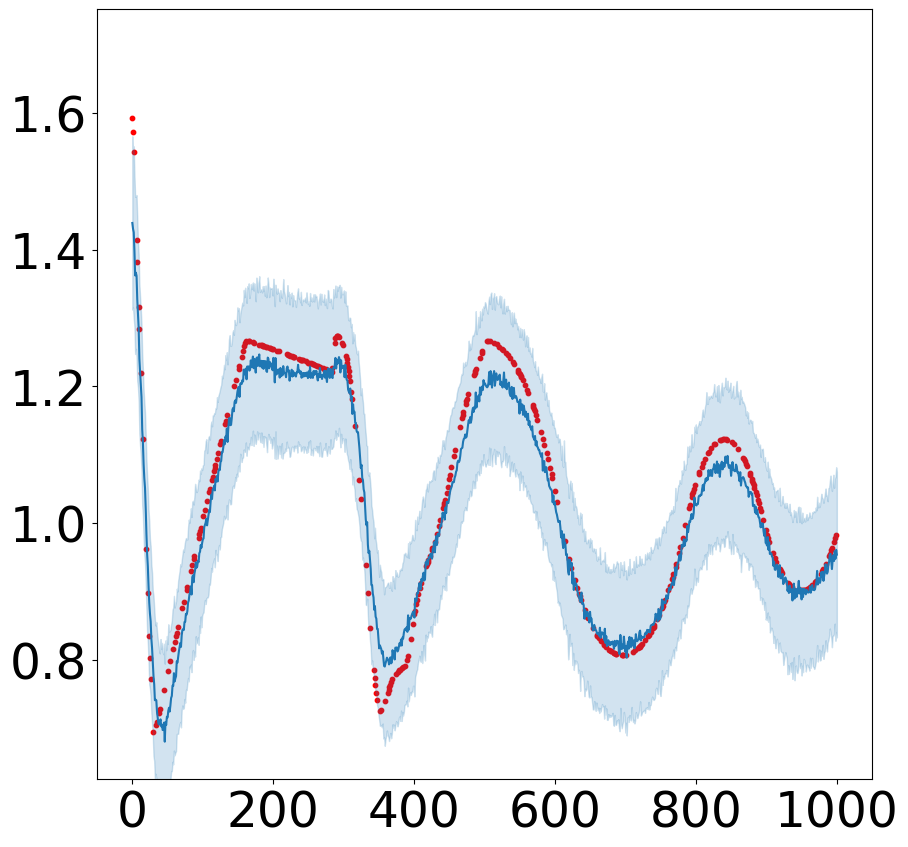

In [4]:
# Define model hyperparameters
num_latent = 15
num_hidden = 32
num_channels = 1
batch_size = 16
slower = True
mode = "missing"
clip_gradient = True
beta = 1.0
seed = 0
kernel = "matern32"
lr_adam = 1e-3
y_dim = 14

# Define the dataset and dataloader
T = 1000
test_dataset = SequenceDataset(sequence_dir="data/mujoco_1000_slower/missing_sequences_1000_slower")
iters = 500
plot_files = [
    "model_checkpoints/mujoco/304.npz", # load a specific sequence on which to make predictions
]

# Define the model
k_t = Matern32(lengthscale=jax.numpy.ones(num_latent)*50, variance=jax.numpy.ones(num_latent))
decoder = decoder_blocks(num_latent, y_dim)
decoder_likelihood = DecoderGaussian(decoder, variance=0.2, num_latent=num_latent, y_dim=y_dim)
encoder = simple_net_block(y_dim, num_hidden)
hidden_to_mu = objax.nn.Sequential(
    [
        Linear(num_hidden, num_latent),
    ]
)
hidden_to_var = objax.nn.Sequential(
    [
        Linear(num_hidden, num_latent),
    ]
)
lik = decoder_likelihood
dt = None
model = MarkovGaussianProcessVAEExternal(
    kernel = k_t,
    likelihood = decoder_likelihood,
    encoder = encoder,
    num_hidden=num_hidden,
    hidden_to_mu=hidden_to_mu,
    hidden_to_var=hidden_to_var,
    num_latent=num_latent,
    dt=dt,
    minibatch_size=batch_size,
    num_sequences=1,
    parallel=False,
    missing_mechanism="missing"
    # time_transform=time_transform
) 

# Load the model checkpoint of trained model
ckpt = objax.io.Checkpoint(logdir=f"model_checkpoints/mujoco/markovgpvae_{seed}_{num_latent}_clip{clip_gradient}_batchsize{batch_size}_lr{lr_adam}_epochs{iters}_T1000_{slower}", keep_ckpts=iters)
ckpt.restore(model.vars(), iters-1)
# note that the model is trained on a dataset generated by a different seed than if you just generate a new dataset

# Make plots
for sequence_to_plot in plot_files[:1]:
    test_dataset.sequence_filenames = [sequence_to_plot]
    sequence_num = sequence_to_plot.split("/")[-1].split(".")[0]
    t_plot = np.linspace(0, T, T) # target time points
    t_train = jax.numpy.array(test_dataset[0][1]) # context time points
    length = test_dataset[0][-2] # length of sequence
    missing_sequence = jax.numpy.array(test_dataset[0][0]) # context sequence
    sequence = jax.numpy.array(test_dataset[0][-1]) # ground truth sequence

    # Make model predictions
    y_mean, y_var, _, _ = model.predict_y(
        t_train, # context time points
        jax.numpy.array(t_plot[:, None]), # target time points
        missing_sequence, # context observations
        jax.numpy.array(test_dataset[0][2]), # context masks
        0, # seed
        20, # number of latent samples for which the predictions are averaged over
    )
    for plot_dim in [3]:
        y_min = np.min(missing_sequence[:int(length),plot_dim])
        y_max = np.max(missing_sequence[:int(length),plot_dim])
        plt.figure(figsize=(10,10))
        plt.plot(t_plot, y_mean[:, plot_dim])
        plt.scatter(t_train[:int(length)], missing_sequence[:int(length),plot_dim], color="red", s=10)
        plt.fill_between(
            t_plot,
            (y_mean - 1.96 * np.sqrt(y_var))[:, plot_dim],
            (y_mean + 1.96 * np.sqrt(y_var))[:, plot_dim],
            color="C0",
            alpha=0.2,
        )
        plt.ylim(y_min*0.90, y_max*1.10)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)

## Training

In [6]:
gpu = -1
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu}"
import numpy as np
import matplotlib.pyplot as plt
from mgpvae.model import MarkovGaussianProcessVAEExternal
from mgpvae.kernels import Matern32
from data.ball_util import SequenceDataset, NumpyLoader
from sklearn.model_selection import train_test_split
from mgpvae.likelihood import DecoderGaussian
import jax
import objax
from jax.config import config
config.update("jax_enable_x64", True)
from mgpvae.networks import Linear

# Define the decoder and encoder networks
def decoder_blocks(nin, nout):
    return objax.nn.Sequential([
        Linear(nin, 16), 
        objax.functional.relu,
        Linear(16, nout), 
    ])
def simple_net_block(nin, n_hidden):
    return objax.nn.Sequential([
        Linear(nin, n_hidden), 
        objax.functional.relu,
    ])

In [16]:
from tqdm import trange, tqdm
from jax import random
from jax.example_libraries.optimizers import clip_grads
minibatch_size = 16
train_dataset = SequenceDataset(sequence_dir="data/mujoco_1000_slower/missing_sequences_1000_slower")
val_dataset = SequenceDataset(sequence_dir="data/mujoco_1000_slower/missing_sequences_1000_slower")
test_dataset = SequenceDataset(sequence_dir="data/mujoco_1000_slower/missing_sequences_1000_slower")
k_t = Matern32(lengthscale=jax.numpy.ones(num_latent)*50, variance=jax.numpy.ones(num_latent))
T = 1000
all_files = train_dataset.sequence_filenames[:500]
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=seed)
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=seed)
train_dataset.sequence_filenames = train_files
val_dataset.sequence_filenames = val_files
test_dataset.sequence_filenames = test_files

train_dataloader = NumpyLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = NumpyLoader(val_dataset, batch_size=20, shuffle=False)
test_dataloader = NumpyLoader(
    test_dataset, batch_size=20, shuffle=False
)
save_interval = 1

In [17]:
# Define training and model hyperparameters
num_latent = 15
num_hidden = 32
num_channels = 1
batch_size = 16
slower = True
mode = "missing"
clip_gradient = True
beta = 1.0
seed = 0
kernel = "matern32"
lr_adam = 1e-3
y_dim = 14
save_interval = 1
iters = 2 # NUMBER OF TRAINING EPOCHS

# Define the dataset and dataloader

# Define the model
k_t = Matern32(lengthscale=jax.numpy.ones(num_latent)*50, variance=jax.numpy.ones(num_latent))
decoder = decoder_blocks(num_latent, y_dim)
decoder_likelihood = DecoderGaussian(decoder, variance=0.2, num_latent=num_latent, y_dim=y_dim)
encoder = simple_net_block(y_dim, num_hidden)
hidden_to_mu = objax.nn.Sequential(
    [
        Linear(num_hidden, num_latent),
    ]
)
hidden_to_var = objax.nn.Sequential(
    [
        Linear(num_hidden, num_latent),
    ]
)
lik = decoder_likelihood
dt = None
model = MarkovGaussianProcessVAEExternal(
    kernel = k_t,
    likelihood = decoder_likelihood,
    encoder = encoder,
    num_hidden=num_hidden,
    hidden_to_mu=hidden_to_mu,
    hidden_to_var=hidden_to_var,
    num_latent=num_latent,
    dt=dt,
    minibatch_size=batch_size,
    num_sequences=1,
    parallel=False,
    missing_mechanism="missing"
    # time_transform=time_transform
) 


In [18]:
if mode == "missing":
    t = np.arange(0, T)[:, None].astype(np.float64)
    y_test = test_dataset[0][0]
    t_input = test_dataset[0][1]
    seq_length_test = int(test_dataset[0][3])
    y_test = y_test[:seq_length_test]
    t_input = t_input[:seq_length_test]
    y_test_true = test_dataset[0][-1]
    t_input_all = np.arange(0, T)[:, None].astype(np.float64)

opt_hypers = objax.optimizer.Adam(model.vars())
energy = objax.GradValues(model.energy_batch, model.vars())
ckpt = objax.io.Checkpoint(logdir=f"results/mujoco_mode{mode}/markovgpvae_{seed}_{num_latent}_clip{clip_gradient}_batchsize{batch_size}_lr{lr_adam}_epochs{iters}_T1000_{slower}", keep_ckpts=iters)


@objax.Function.with_vars(opt_hypers.vars() + model.vars())
def train_op(epoch, y_train, mask_train, t_train=None):
    dE, (E, negative_varexp, kl) = energy(
        y_train,
        random.split(random.PRNGKey(epoch), batch_size),
        mask_train,
        t=t_train,
        num_samples=1,
    )  # compute energy and its gradients w.r.t. hypers

    if clip_gradient:
        dE = clip_grads(dE, 100)
    opt_hypers(lr_adam, dE)
    return E, negative_varexp, kl


train_op = objax.Jit(train_op)
# t = np.linspace(0, train_dataset[0][0].shape[0]-1, train_dataset[0][0].shape[0])[:, None]
best_val_rmse = None
best_val_epoch = 0

iterator = trange(iters)
for i in iterator:

    epoch_loss = []
    epoch_negative_varexp = []
    epoch_kl = []
    if mode == "missing":
        for j, sample in enumerate(train_dataloader):
            missing_sequence, t_train, missing_mask, _, sequence = sample
            loss, negative_varexp, kl = train_op(
                epoch=j, y_train=missing_sequence, mask_train=missing_mask, t_train=t_train
            )
            iterator.set_description(
                f"EPOCH {i}:{j}/{len(train_dataset.sequence_filenames) // batch_size}, ELBO: {loss:1.4f}, negative_varexp: {negative_varexp:1.4f}, KL: {kl:1.4f}, best_val_rmse: {best_val_rmse}"
            )
            epoch_loss.append(loss)
            epoch_negative_varexp.append(negative_varexp)
            epoch_kl.append(kl)
    
    if i % save_interval == 0:

        ckpt.save(model.vars(), idx=i)
        # validation/test
        epoch_rmse = []
        for sample in tqdm(val_dataloader):
            missing_sequence, t_train, missing_mask, _, sequence = sample
            
            # compute RMSE
            y_mean, _, _, _ = jax.vmap(model.predict_y, (0, None, 0, 0, 0, None))(
                jax.numpy.array(t_train),
                jax.numpy.array(t_input_all),
                jax.numpy.array(missing_sequence),
                jax.numpy.array(missing_mask),
                jax.numpy.arange(20),
                20,
            )
            rmse = np.sqrt(np.mean(((y_mean - sequence)**2).reshape(20, -1), 1))
            epoch_rmse.append(np.sum(rmse))
        val_rmse = np.sum(epoch_rmse) / len(val_dataset)
        if best_val_rmse is None or val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_val_epoch = i
            objax.io.save_var_collection(f"results/mujoco_mode{mode}/markovgpvae_{seed}_{num_latent}_clip{clip_gradient}_batchsize{batch_size}_lr{lr_adam}_epochs{iters}_T1000_{slower}/best.npz", model.vars())
        
        # wandb.log({"val_rmse": val_rmse, "Epoch": i})
        # wandb.log({"Epoch ELBO": np.mean(epoch_loss), "Epoch negative_varexp": np.mean(epoch_negative_varexp), "Epoch KL": np.mean(epoch_kl), "val_rmse": val_rmse, "Epoch": i})


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]
EPOCH 1:19/20, ELBO: 14272.1703, negative_varexp: 13705.8454, KL: 566.3249, best_val_rmse: 1.249441667841356: 100%|██████████| 2/2 [00:57<00:00, 28.89s/it]


In [19]:
ckpt.restore(model.vars(), best_val_epoch)
epoch_rmse = []
epoch_nll = []
for sample in tqdm(test_dataloader):
    missing_sequence, t_train, missing_mask, _, sequence = sample
    nll = model.compute_nll(
        t_input=t_train, 
        y_input=missing_sequence, 
        t_test=t_input_all,
        y_test=sequence, 
        mask_input=missing_mask,
        seed=0,
        num_samples=20
    )
    y_mean, _, _, _ = jax.vmap(model.predict_y, (0, None, 0, 0, 0, None))(
        jax.numpy.array(t_train),
        jax.numpy.array(t_input_all),
        jax.numpy.array(missing_sequence),
        jax.numpy.array(missing_mask),
        jax.numpy.arange(20),
        20,
    )
    rmse = np.sqrt(np.mean(((y_mean - sequence)**2).reshape(20, -1), 1))
    epoch_rmse.append(np.sum(rmse))
    epoch_nll.append(nll)

Resuming from results/mujoco_modemissing/markovgpvae_0_15_clipTrue_batchsize16_lr0.001_epochs2_T1000_True/ckpt/0000000001.npz


100%|██████████| 5/5 [00:46<00:00,  9.36s/it]


In [20]:
print("best_test_rmse", np.sum(epoch_rmse) / len(test_dataset))
print("best_test_nll", np.sum(epoch_nll) / len(test_dataset))
print("best_val_epoch", best_val_epoch)

best_test_rmse 0.9557739721285471
best_test_nll 33946.96416926813
best_val_epoch 1
